### Medical abstracts describe the current conditions of a patient. Doctors routinely scan dozens or hundreds of abstracts each day as they do their rounds in a hospital and must quickly pick up on the salient information pointing to the patient’s malady. You are trying to design assistive technology that can identify, with high precision, the class of problems described in the abstract. In the given dataset, abstracts from 5 different conditions have been included: digestive system diseases, cardiovascular diseases, neoplasms, nervous system diseases, and general pathological conditions.

* Choose appropriate techniques for modeling text.
* Implement the k-nearest neighbor classifier (cannot use libraries for this algorithm).
* Use your version of the k-NN classifier to assign classes to medical texts.
* Think about dealing with imbalanced data.
* Evaluate results using the F1 Scoring Metric.

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

In [2]:
# utility to read data as panda dataframe

def give_me_a_frame(data_location):
    return pd.read_csv(
        filepath_or_buffer=data_location, 
        header=None, 
        sep='\n')

In [3]:
# utility to perform preprocessing tests

def preprocess(statements):

    s = set(stopwords.words('english'))
    stemmer = WordNetLemmatizer()
    table = str.maketrans('', '', string.punctuation)
    digit_table = str.maketrans('', '', string.digits)
    
    result = []
    for statement in statements:
#       after lowercasing the sentence, remove digits, stopwords and lematization
        
        statement = statement.lower()
        temp = list(filter(lambda w: not w in s,statement.split()))
        stripped_punc_fix = [w.translate(table) for w in temp]
        stripped_digit_fix = [w.translate(digit_table) for w in stripped_punc_fix]
        stripped_wordlen_fix = [d for d in stripped_digit_fix if len(d) > 1]
        stripped_stemmer_fix = [stemmer.lemmatize(stemmer_word) for stemmer_word in stripped_wordlen_fix]
        result.append(" ".join(stripped_stemmer_fix))

    return result

In [4]:
# utility to transform a bag of words to csr-matrix

def build_matrix(train, test, n):
    vectorizer = TfidfVectorizer(norm='l2'
                                 ,ngram_range=(1,n)
                                 ,min_df=3 
                                )
    return vectorizer.fit_transform(train),vectorizer.transform(test)

In [5]:
# utility to predict output class of a single input object using k-nearest neighbors

def predict_output(train_matrix, test_vector, train_classes,  k=3 ):
    dot_product = test_vector.dot(train_matrix.T)
    sims = list(zip(dot_product.indices, dot_product.data))
    sims.sort(key=lambda x: x[1], reverse=True)
    
#     take majority vote instead of using inverse similarity, decreased performance
#     tc = Counter(train_classes[s[0]] for s in sims[:k]).most_common()
#     if len(tc) < 2 or tc[0][1] > tc[1][1]:
#             # majority vote
#             return tc[0][0]

    tc = defaultdict(float)
    for s in sims[:k]:
                tc[train_classes[s[0]]] += s[1]
    return sorted(tc.items(), key=lambda x: x[1], reverse=True)[0][0]

In [6]:
def splitData(mat, cls, fold=1, d=10):
    r""" Split the matrix and class info into train and test data using d-fold hold-out
    """
    n = mat.shape[0]
    r = int(np.ceil(n*1.0/d))
    print(r)
    mattr = []
    clstr = []
    # split mat and cls into d folds
    for f in range(d):
#         if f+1 != fold:
            mattr.append( mat[f*r: min((f+1)*r, n)] )
            clstr.extend( cls[f*r: min((f+1)*r, n)] )
#     print(mattr)
    # join all fold matrices that are not the test matrix
    train = sp.vstack(mattr)
    # extract the test matrix and class values associated with the test rows
#     test = mat[(fold-1)*r: min(fold*r, n), :]
#     clste = cls[(fold-1)*r: min(fold*r, n)]

    return train, clstr

In [7]:
# peform steps on the train data to view evaluation

def classify(statements, statements_test, classes, c, k):
    
    statements = preprocess(statements)
    statements_test = preprocess(statements_test)
    classes = np.array(classes)
    X_Train, X_test = build_matrix(statements,statements_test,c)
    
#   fix unbalanced data set
    nm = SMOTE(random_state=21)
    X_res, y_res = nm.fit_sample(X_Train, classes)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=21)
    y_pred = [predict_output(X_train,x,y_train,k) for x in X_test]
    print(precision_recall_fscore_support(y_test, y_pred, average='macro'))

### The goal is to develop predictive models that can determine, given a particular medical abstract, which one of 5 classes it belongs to. As such, the goal would be to develop the best classification model, with the restriction that only use your own implementation of the k-NN classifier. There are many choices in text pre-processing and modeling, proximity measures, and classifier meta-parameters that will lead to many different solutions for the problem.

In [12]:
df = give_me_a_frame('../data/train.dat')   
df = pd.DataFrame(df[0].str.split('\t', 1).tolist())
statements = df[1]
classes = df[0]

# n, bins, patches = plt.hist(classes)
# plt.show()

df = give_me_a_frame('../data/test.dat')
statements_test = df[0]

In [13]:
statements = preprocess(statements)
statements_test = preprocess(statements_test)
classes = np.array(classes)
# df = pd.DataFrame({'aaj':statements})

print(statements[:1])
# df[df['aaj'].str.contains('acut')]


X_Train, X_test = build_matrix(statements,statements_test,2)

['catheterization laboratory event hospital outcome direct angioplasty acute myocardial infarction ass safety direct infarct angioplasty without antecedent thrombolytic therapy catheterization laboratory hospital event assessed consecutively treated patient infarction involving left anterior descending patient right circumflex coronary artery group patient similar age left anterior descending coronary artery year right coronary artery year circumflex coronary artery year patient multivessel disease left anterior descending coronary artery right coronary artery circumflex coronary artery patient initial grade antegrade flow left anterior descending coronary artery right coronary artery circumflex coronary artery cardiogenic shock present eight patient infarction left anterior descending coronary artery four infarction right coronary artery four infarction circumflex coronary artery major catheterization laboratory event cardioversion cardiopulmonary resuscitation dopamine intraaortic ba

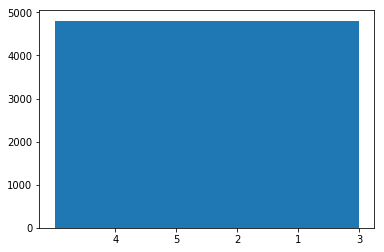

In [14]:
nm = SMOTE(random_state=21)
X_res, y_res = nm.fit_sample(X_Train, classes)
labels, values = zip(*Counter(y_res).most_common())
indexes = np.arange(len(labels))
width = 1
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=21)
# X_train, x_test, y_train, y_test = train_test_split(X_Train, classes, test_size=0.33, random_state=21)

# # X_train.append(x_test)
X_train = sp.vstack([X_train,x_test])
# # y_train.extend(y_test)
y_train = np.append(y_train,y_test)
# # y_pred = [predict_output(X_train,x,y_train,8) for x in X_test]
# print(X_train.shape[0])
# print(y_train.shape[0])

with open('out.dat', 'w') as f:
    for i in range(X_test.shape[0]):
        f.write("%s\n" % (predict_output(X_train, X_test[i], y_train, 73)))
        
# clspr = [predict_output(X_Train, x_test, classes, 5) for x_test in X_test]
# print(clspr)
# aaj = cosine_similarity(X_test[:1],X_Train).flatten()
# kal = X_test[:1].dot(X_Train.T)
# similar_docs = aaj.argsort()[:-6:-1]
# statements = np.array(statements)
# classes = np.array(classes)
# print(similar_docs)
# print(classes[similar_docs])
# print(kal)

### Evaluate training data

In [ ]:
for c in range(2,3):
    for k in range(73,74):
        classify(statements, statements_test, classes, c, k)